# UDA Final Project - Python Code

### Setup

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
np.random.seed(30224)

from matplotlib import pyplot as plt
%matplotlib inline

### Data Extraction via Spotify API (For Reference)

In [16]:
# Create Spotify client object for data crawling

# !pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

# Error handling
from spotipy import SpotifyException

path = 'spotipy_service_account_credentials.json'
credentials = json.load(open(path))

# Authentication with SDA credentials
client_credentials_manager = SpotifyClientCredentials(client_id=credentials['client_id'], 
                                                      client_secret=credentials['client_secret'])

# Create sp object
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [17]:
# Data Extraction from Spotify Public API (via spotipy)

##########################################################################
# Step 1: Specify list of major genres to analyse
genres = ['pop',
          'hiphop',
          'rnb',
          'rock',
          'alternative',
          'kpop',
          '0JQ5DAqbMKFHOzuVTgTizF'] # Dance/Electronic

##########################################################################
# Step 2: Get top playlists within Spotify's major categories
playlists = []
for genre in genres:
    try:
        results_p = sp.category_playlists(genre, limit=50)
        playlists_items = results_p['playlists']['items']
        playlists.extend([playlists_items[i]['id'] for i in range(len(playlists_items)) if playlists_items[i] is not None])

        ## Looper method to extract beyond first 50 playlists
        while results_p['playlists']['next']:
            results_p = sp.next(results_p['playlists'])
            playlists_items = results_p['playlists']['items']
            playlists.extend([playlists_items[i]['id'] for i in range(len(playlists_items)) if playlists_items[i] is not None])

    except SpotifyException:
        print(f'Category ID {genre} not found')

## Remove duplicate playlists
playlists = list(set(playlists))

##########################################################################
# Step 3: For each playlist, pull out all artists featured in playlist
tracks = []
for pid in playlists:
    try:
        results_t = sp.playlist_items(pid)
        tracks_items = results_t['items']

        # Extract only the popular tracks (popularity >= 75)
        tracks.extend([tracks_items[i]['track'] for i in range(len(tracks_items)) 
                       if (tracks_items[i] is not None) 
                       and (tracks_items[i]['track'] is not None) 
                       and (tracks_items[i]['track']['popularity']>=75)
                       ])

        ## Looper method to extract beyond first 100 tracks
        while results_t['next']:
            results_t = sp.next(results_t)
            tracks_items = results_t['items']
            tracks.extend([tracks_items[i]['track'] for i in range(len(tracks_items)) 
                           if (tracks_items[i] is not None) 
                           and (tracks_items[i]['track'] is not None) 
                           and (tracks_items[i]['track']['popularity']>=75)
                           ])
    
    except SpotifyException:
        print(f'Playlist ID {pid} not found')

## Construct artist_id:artist_name dictionary
## Use only the first artist attributed for each track (i.e. major contributing artist)
artists_dict = dict(zip(
    [tracks[i]['artists'][0]['id'] for i in range(len(tracks)) if tracks[i] is not None],
    [tracks[i]['artists'][0]['name'] for i in range(len(tracks)) if tracks[i] is not None]
    ))

In [51]:
##########################################################################
# Step 4: For each artist, get similar artists to construct edge list
edgelist = pd.DataFrame()
for aid in list(artists_dict.keys()):
       
    results_ra = sp.artist_related_artists(aid)
    related_artists = [results_ra['artists'][i]['name'] for i in range(len(results_ra['artists']))]

    related_artists_edgelist = pd.DataFrame(
        {'source':[artists_dict[aid] for i in range(len(related_artists))],
            'target':related_artists}
        )
    
    ## Append to final edgelist
    edgelist = pd.concat([edgelist, related_artists_edgelist], ignore_index=True)

In [52]:
print('Number of edges: ', edgelist.shape[0])
print('Number of nodes (i.e. unique artists): ', len(set(edgelist['source'].to_list() + edgelist['target'].to_list())))

Number of edges:  15329
Number of nodes (i.e. unique artists):  5666


In [54]:
# Prune dataset by keeping only target artists which are also featured in source artist
source_artists = set(edgelist['source'])
edgelist_reduced = edgelist.loc[edgelist['target'].isin(source_artists), :].copy().reset_index(drop=True)

print('Number of edges: ', edgelist_reduced.shape[0])
print('Number of nodes (i.e. unique artists): ', len(set(edgelist_reduced['source'].to_list() + edgelist_reduced['target'].to_list())))

Number of edges:  4312
Number of nodes (i.e. unique artists):  723


In [55]:
edgelist_reduced.to_csv('CID00690532_UDA_FinalProject_Dataset.csv', index=False, encoding='utf-8-sig')

In [18]:
##########################################################################
# Step 5 (optional): Extract number of followers for each artist (useful for ranking artists)
artists_followers = {}

for aid in list(artists_dict.keys()):
    results_a = sp.artist(aid)
    artists_followers.update({artists_dict[aid]:results_a['followers']['total']})

artists_followers = pd.DataFrame.from_dict({'artist':list(artists_followers.keys()),
                                            'followers':list(artists_followers.values())})
artists_followers.to_csv('spotify_artist_followers.csv', index=False, encoding='utf-8-sig')

### Network Analysis

In [2]:
# Import necessary modules
import networkx as nx
import networkx.algorithms.community as nx_comm

In [3]:
# Load data
edgelist = pd.read_csv('CID00690532_UDA_FinalProject_Dataset.csv', encoding='utf-8-sig')
G = nx.from_pandas_edgelist(edgelist, create_using=nx.MultiGraph)
G = G.to_undirected()

print('The Spotify Similar Artists network has {} nodes (artists) and {} edges'.format(len(G.nodes), len(G.edges)))

The Spotify Similar Artists network has 723 nodes (artists) and 4312 edges


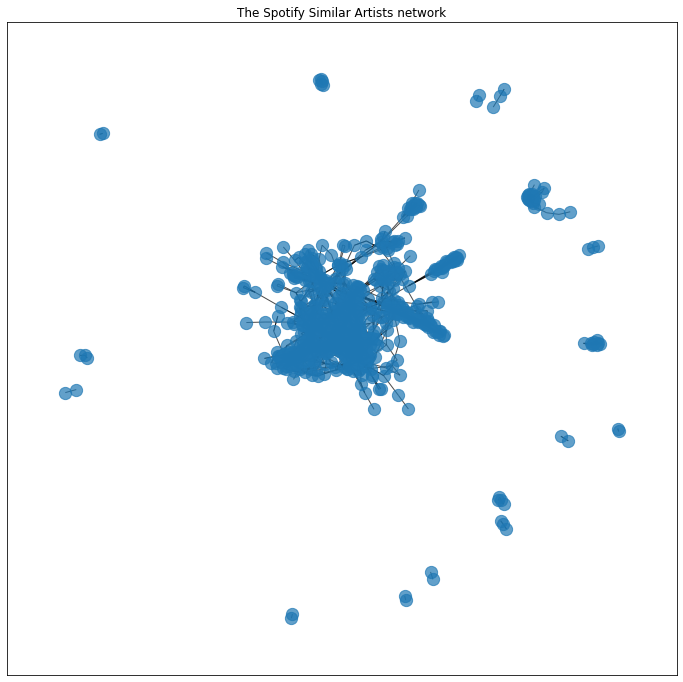

In [4]:
# Visualise graph
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, seed=70103)
nx.draw_networkx(G, pos, node_size=150, alpha=0.7, with_labels=False)
plt.title('The Spotify Similar Artists network')
plt.show();

### Graph Embedding

In [5]:
# Import necessary modules
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [6]:
# Train node2vec embedding
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Retrieve node embeddings and corresponding subjects
node_embeddings = (model.wv.vectors)
node_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(node_embeddings)

Computing transition probabilities:   0%|          | 0/723 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:21<00:00,  9.24it/s]


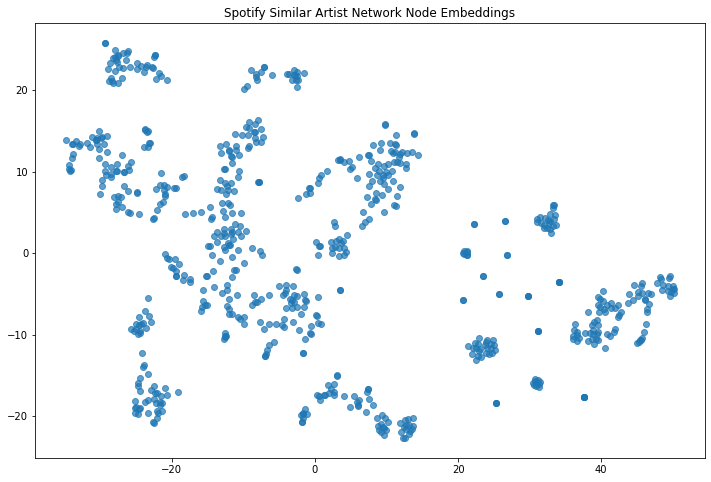

In [7]:
# Visualise graph in 2D embedding
plt.figure(figsize=(12,8))
# plt.axes().set(aspect="equal")
plt.scatter(
    node_embedded[:,0],
    node_embedded[:,1],
    alpha=0.7,
)
plt.title("Spotify Similar Artist Network Node Embeddings")
plt.show();

### Community Detection

In [8]:
# Find communities using the Louvain Community Detection Algorithm
partitions = list(nx.community.louvain_partitions(G, seed=70103))

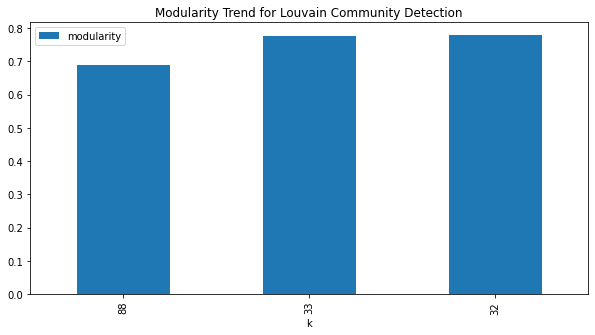

In [9]:
# Calculate modularity at each partition
modularity_df = pd.DataFrame(
    [[len(partitions[k]), nx.community.modularity(G, partitions[k])] for k in range(len(partitions))],
    columns=["k", "modularity"],
)

# Plot modularity
modularity_df.plot.bar(
    x="k",
    title="Modularity Trend for Louvain Community Detection",
    figsize=(10,5)
)
plt.show();

In [10]:
# Find max modularity and corresponding number of communities
best_k_idx = modularity_df['modularity'].idxmax()
best_n = len(partitions[best_k_idx])
best_modularity = modularity_df.loc[best_k_idx, "modularity"]

print(f'Optimal number of communities detected using Louvain Algorithm : {best_n}')
print(f'Modularity of communities detected using Louvain Algorithm: {best_modularity}')

Optimal number of communities detected using Louvain Algorithm : 32
Modularity of communities detected using Louvain Algorithm: 0.7783443365539842


In [11]:
# Load artist followers to help us rank artists by size
artists_followers = pd.read_csv('spotify_artist_followers.csv', encoding='utf-8-sig')
artists_followers = dict(zip(
    artists_followers['artist'],
    artists_followers['followers']
))

In [12]:
# Order communities by size
communities = partitions[best_k_idx]
communities.sort(key=len, reverse=True)

for i,r in enumerate(communities):
    filtered_artists = dict(filter(lambda x: x[0] in r, artists_followers.items()))
    sorted_artists = dict(sorted(filtered_artists.items(), key=lambda x:x[1], reverse=True))

    # Print out top 10 artists in each community
    print(f'Community {i+1}: {list(sorted_artists.keys())[:10]}')
    print(f'Community Size: {len(r)}', '\n')

Community 1: ['Lana Del Rey', 'Arctic Monkeys', 'The Neighbourhood', 'Lorde', 'Luke Combs', 'Cigarettes After Sex', 'Joji', 'Conan Gray', 'Måneskin', 'Troye Sivan']
Community Size: 71 

Community 2: ['Drake', 'The Weeknd', 'XXXTENTACION', 'Post Malone', 'Juice WRLD', 'Kendrick Lamar', 'Travis Scott', 'Kanye West', 'J. Cole', 'Lil Uzi Vert']
Community Size: 70 

Community 3: ['Linkin Park', 'Red Hot Chili Peppers', 'Nirvana', 'Green Day', 'Foo Fighters', 'Gorillaz', 'Fall Out Boy', 'System Of A Down', 'Daft Punk', 'Oasis']
Community Size: 64 

Community 4: ['Bad Bunny', 'KAROL G', 'Ozuna', 'J Balvin', 'Maluma', 'Anuel AA', 'Daddy Yankee', 'Shakira', 'Sebastian Yatra', 'Rauw Alejandro']
Community Size: 62 

Community 5: ['Ed Sheeran', 'Rihanna', 'Adele', 'Bruno Mars', 'Imagine Dragons', 'Coldplay', 'Maroon 5', 'Beyoncé', 'Katy Perry', 'Lady Gaga']
Community Size: 60 

Community 6: ['Nicki Minaj', 'Doja Cat', 'Cardi B', 'SZA', 'Khalid', 'Frank Ocean', 'Megan Thee Stallion', 'Bryson Tiller

Text(0.5, 1.0, 'The Spotify Similar Artist network grouped by Clusters')

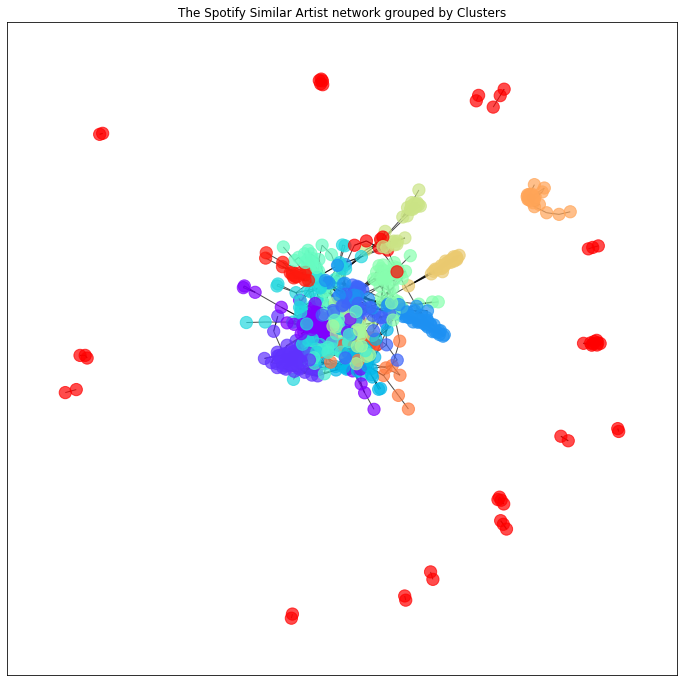

In [13]:
# Visualise clusters on network diagram

# Create color map for labels
labels = {}
i = 0
for c in communities:
    for node in c:
        labels.update({node:i})
    i += 1

# labels = dict(sorted(labels.items(), key=lambda item: item[0]))
unique_labels = sorted(set(labels.values()))
cmap = cm.rainbow(np.array(unique_labels)/np.mean(unique_labels))

# Visualise graph with clusters
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, seed=70103)
nx.draw_networkx(G, pos, node_color=cmap[[labels[n] for n in G.nodes]], node_size=150, alpha=0.7, with_labels=False)
plt.title('The Spotify Similar Artist network grouped by Clusters')

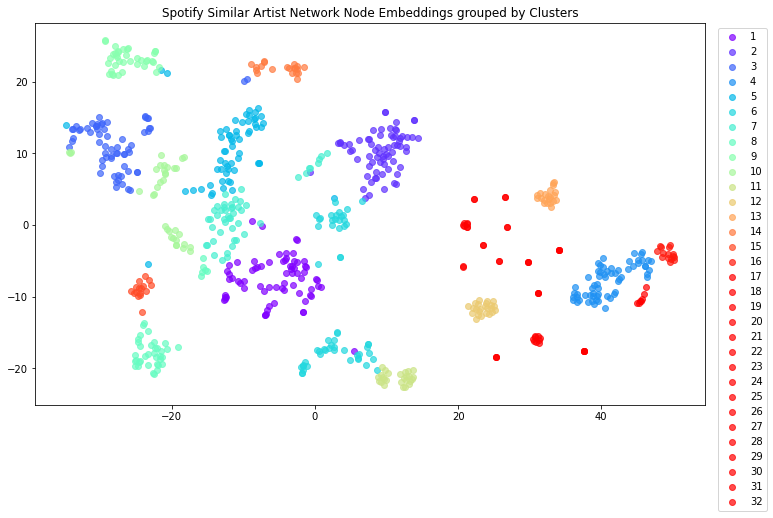

In [16]:
# Visualise graph with clusters in 2D embedding
plt.figure(figsize=(12,12))
plt.axes().set(aspect="equal")

n_limit = 32

node_ids = model.wv.index_to_key
for c in range(n_limit):
    idx = [node_ids.index(i) for i in labels if labels[i]==c]
    plt.scatter(
        node_embedded[idx,0],
        node_embedded[idx,1],
        color=cmap[c],
        alpha=0.7,
    )

plt.legend(range(1,n_limit+1), loc='upper right', bbox_to_anchor=(1.1,1))
plt.title("Spotify Similar Artist Network Node Embeddings grouped by Clusters")
plt.show();

### Largest Connected Subgraph

In [18]:
# Extract largest connected subgraph
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

Text(0.5, 1.0, 'Largest Connected Subgraph')

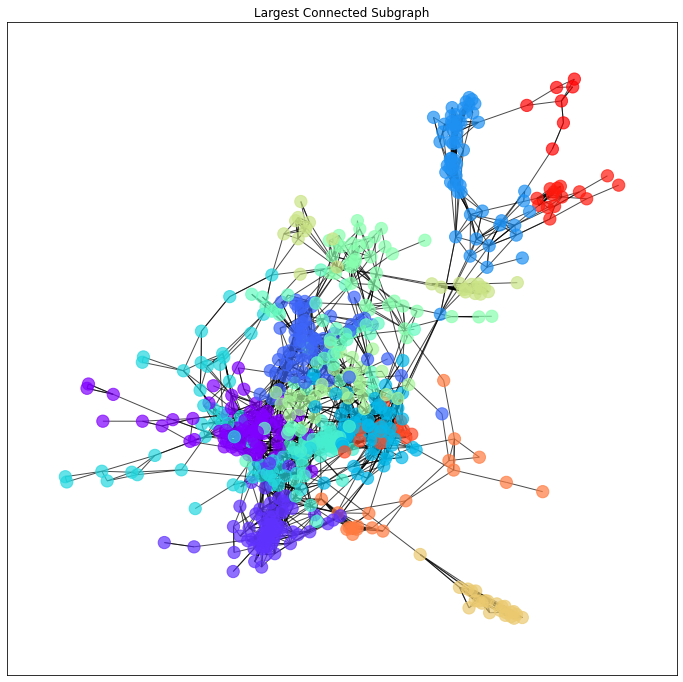

In [19]:
# Visualise graph with clusters
plt.figure(figsize=(12,12))
pos = nx.spring_layout(H, seed=70103)
nx.draw_networkx(H, pos, node_color=cmap[[labels[n] for n in H.nodes]], node_size=150, alpha=0.7, with_labels=False)
plt.title('Largest Connected Subgraph')

In [54]:
# Calculate shortest path between any 2 communities (focusing on first 16 communities in connected subgraph)
pathlengths = nx.all_pairs_shortest_path_length(H)
dpathlengths = {x[0]:x[1] for x in pathlengths}

# Create matrix of path lengths
pathlengths_matrix = pd.DataFrame(index=range(16), columns=range(16))
for i in range(32):
    for j in range(32):
        path_list = []

        for artist_i in communities[i]:
            for artist_j in communities[j]:
                if artist_i != artist_j:
                    try:
                        path_list.append(dpathlengths[artist_i][artist_j])
                    except KeyError:
                        pass

        pathlengths_matrix.loc[i,j] = np.mean(path_list)

# Drop unconnected communities
pathlengths_matrix.drop([12, 16] + list(range(18,32)), axis=0, inplace=True)
pathlengths_matrix.drop([12, 16] + list(range(18,32)), axis=1, inplace=True)

# Convert to float
pathlengths_matrix = pathlengths_matrix.astype(float)

c:\Users\jingx\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jingx\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot: >

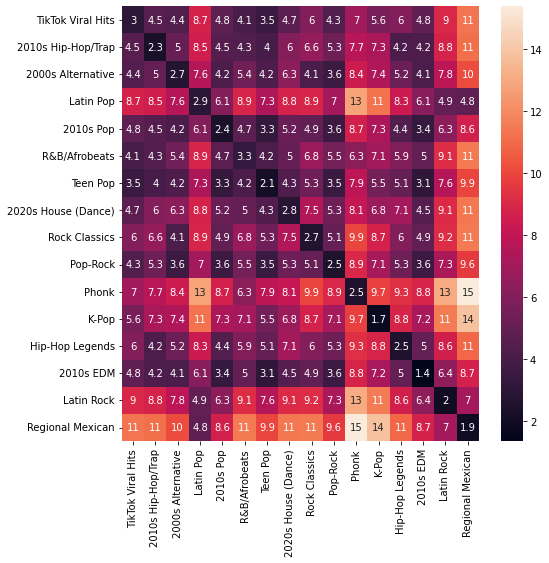

In [56]:
# Plot heatmap of average linkage community distances
import seaborn as sns

community_labels = ['TikTok Viral Hits', '2010s Hip-Hop/Trap', '2000s Alternative', 'Latin Pop',
                    '2010s Pop', 'R&B/Afrobeats', 'Teen Pop', '2020s House (Dance)',
                    'Rock Classics', 'Pop-Rock', 'Phonk', 'K-Pop',
                    'Hip-Hop Legends', '2010s EDM', 'Latin Rock', 'Regional Mexican']

pathlengths_matrix.index = community_labels
pathlengths_matrix.columns = community_labels

plt.figure(figsize=(8,8))
sns.heatmap(pathlengths_matrix, annot=True)

### Betweenness Centrality

In [58]:
# Compute centrality
centrality = nx.betweenness_centrality(H)

Top 20 Artists with Highest Centrality Scores:
('Enrique Iglesias', 0.2217798156738473)
('Shakira', 0.12027850534057184)
('Kesha', 0.10032021706960303)
('Flo Rida', 0.0952214238169881)
('xxanteria', 0.07893676920585987)
('Pitbull', 0.07893304952527028)
('KAROL G', 0.07822559482066531)
('JVKE', 0.07459723313319938)
('FIFTY FIFTY', 0.06786812023873443)
('PinkPantheress', 0.06682728435025719)
('ZWE1HVNDXR', 0.065291368375024)
('Coldplay', 0.060492211977299766)
('Taio Cruz', 0.05972104340468007)
('Kanii', 0.05918448669010971)
('Kenya Grace', 0.051274722524376065)
('Juanes', 0.04678533290375326)
('The Weeknd', 0.045322921472867615)
('Ice Spice', 0.04394830437074795)
('The Neighbourhood', 0.04239773184248996)
('U2', 0.041416882766428235)


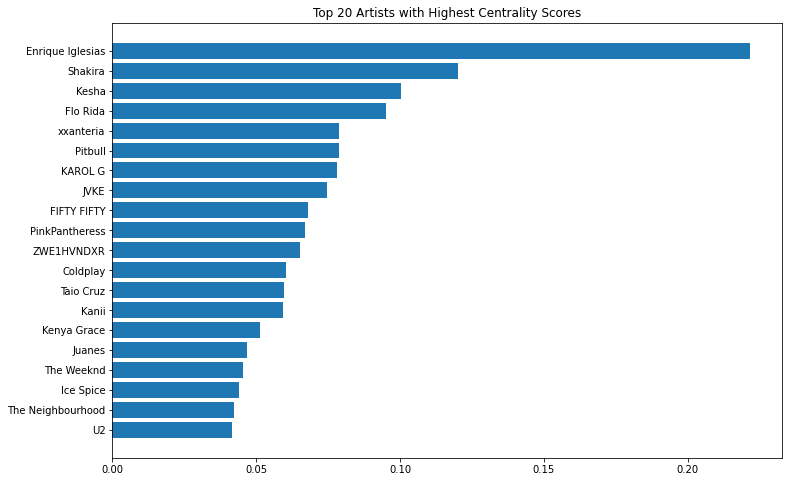

In [62]:
# List out top 20 artists with highest centrality scores
print('Top 20 Artists with Highest Centrality Scores:')
sorted_centrality = dict(sorted(centrality.items(), key=lambda x:x[1], reverse=True))
for i in range(20):
    print(list(sorted_centrality.items())[i])

plt.figure(figsize=(12,8))
plt.barh(list(sorted_centrality.keys())[19::-1], list(sorted_centrality.values())[19::-1])
plt.title('Top 20 Artists with Highest Centrality Scores')
plt.show();

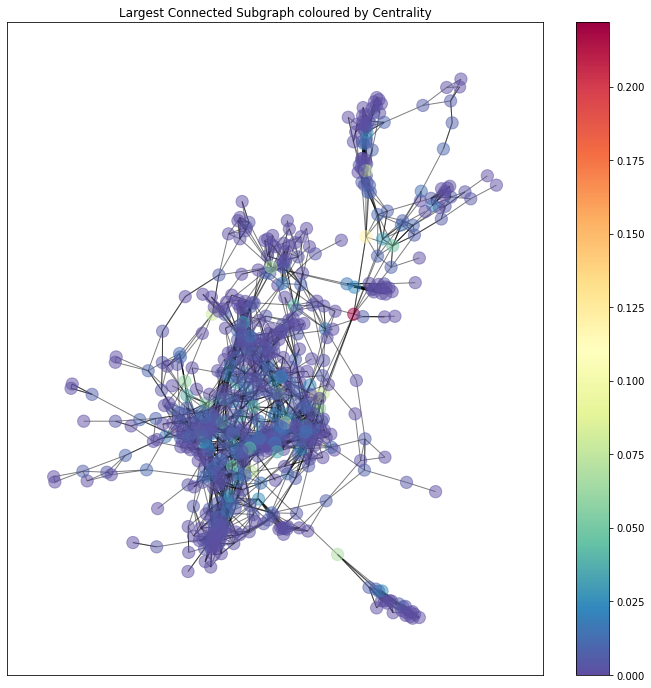

In [152]:
# Visualise graph colored by centrality score
cmap_centrality = plt.cm.Spectral_r

plt.figure(figsize=(12,12))
pos = nx.spring_layout(H, seed=70103)
nx.draw_networkx(H, pos, node_color=[centrality[node] for node in H.nodes], cmap=cmap_centrality, node_size=150, alpha=0.5, with_labels=False)
plt.title('Largest Connected Subgraph coloured by Centrality')

sm = plt.cm.ScalarMappable(cmap=cmap_centrality, norm=plt.Normalize(vmin=min(centrality.values()), vmax=max(centrality.values())))
plt.colorbar(sm)
plt.show();

Text(0.5, 1.0, 'Top Artists with Highest Centrality')

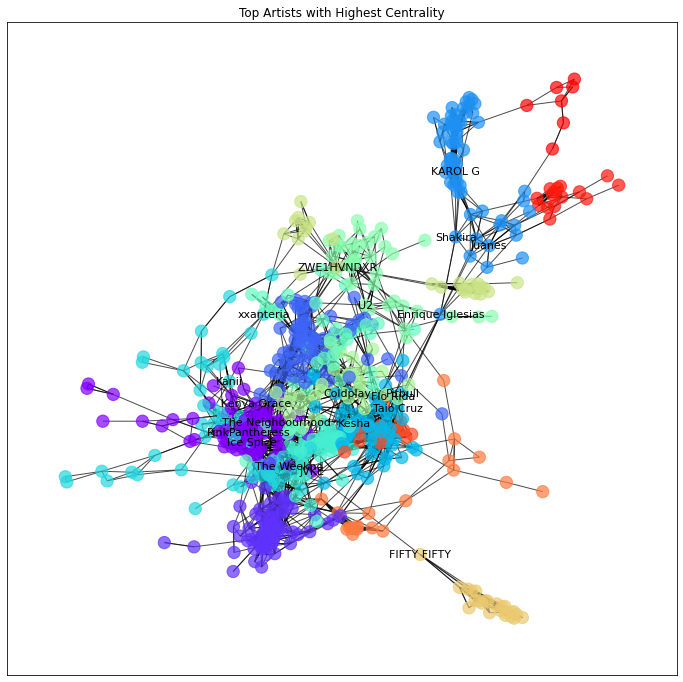

In [156]:
# Visualise graph with clusters
node_labels = {}
for node in H.nodes():
    if (node in list(sorted_centrality.keys())[:20]):
        node_labels[node] = node

plt.figure(figsize=(12,12))
pos = nx.spring_layout(H, seed=70103)
nx.draw_networkx(H, pos, node_color=cmap[[labels[n] for n in H.nodes]], node_size=150, alpha=0.7, with_labels=False)
nx.draw_networkx_labels(H, pos, labels=node_labels, font_size=11, font_color='k')
plt.title('Top Artists with Highest Centrality')

plt.show();